# Capstone Phase 2 - SVM  
Previous phase 2 notebook was getting a bit long, so modeling is continued here.

### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

### Some utility stuff

In [4]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [5]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [6]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply transformations identified during exploration phase

In [7]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [8]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [9]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [10]:
class_names = list(label_encoder.classes_)

### Load feature subsets

In [11]:
feature_subsets = joblib.load('./data/feature_subsets.pkl')

In [12]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
rf.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1)

In [15]:
y_pred_rf = cross_val_predict(rf, training_data_std, y_train, cv=3, n_jobs=-1)  # save the test set for final models

In [16]:
y_pred_rf

array([6, 6, 3, ..., 5, 5, 5])

In [19]:
joblib.dump(rf, './data/rf-100-16.pkl')

['./data/rf-100-16.pkl']

In [14]:
rf = joblib.load('./data/rf-100-16.pkl')

That was pretty quick, let's run a grid-search to look for parameters before going further

In [19]:
params = {'n_estimators':[100, 200, 500], 'max_leaf_nodes':[8, 16, 32], 'class_weight':['balanced', 'balanced_subsample']}
rf_gs = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [20]:
rf_gs_results = rf_gs.fit(training_data_std, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [25]:
joblib.dump(rf_gs, './data/rf_gs.pkl')
joblib.dump(rf_gs_results, './data/rf_gs_results')

['./data/rf_gs_results']

In [21]:
print(rf_gs_results.best_estimator_)
print(rf_gs_results.best_params_)
print(rf_gs_results.best_score_)

RandomForestClassifier(class_weight='balanced_subsample', max_leaf_nodes=32,
                       n_estimators=500)
{'class_weight': 'balanced_subsample', 'max_leaf_nodes': 32, 'n_estimators': 500}
0.676920971136243


The number of estimators and leaf nodes are the maximum values in our search, maybe we should try going higher.

In [22]:
params_2 = {'n_estimators':[500, 750, 1000], 'max_leaf_nodes':[32, 64, 128]}
rf_gs_2 = GridSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), params_2, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [23]:
rf_gs_2_results = rf_gs_2.fit(training_data_std, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [26]:
joblib.dump(rf_gs_2, './data/rf_gs_2.pkl')
joblib.dump(rf_gs_2_results, './data/rf_gs_2_results')

['./data/rf_gs_2_results']

In [24]:
print(rf_gs_2_results.best_params_)
print(rf_gs_2_results.best_score_)

{'max_leaf_nodes': 128, 'n_estimators': 750}
0.7117673561802431


In [32]:
rf_best = RandomForestClassifier(n_estimators=750, max_leaf_nodes=128, class_weight='balanced_subsample', n_jobs=-1)
rf_best.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(class_weight='balanced_subsample', max_leaf_nodes=128,
                       n_estimators=750, n_jobs=-1)

In [33]:
joblib.dump(rf_best, './data/rf_best.pkl')

['./data/rf_best.pkl']

In [34]:
# save the test set for final models
y_pred_rf_best = cross_val_predict(rf_best, training_data_std, y_train, cv=3, n_jobs=-1)

In [35]:
y_pred_rf_best

array([1, 6, 3, ..., 5, 5, 5])

In [48]:
#for feature, importance in zip(training_data_std.columns, rf_best.feature_importances_):
#    print(feature, importance)
feature_importances = [(x, y) for x, y in zip(training_data_std.columns, rf_best.feature_importances_)]
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [50]:
joblib.dump(sorted_importances, './data/sorted_feature_importances.pkl')

['./data/sorted_feature_importances.pkl']

              precision    recall  f1-score   support

           0       0.16      0.31      0.21      2000
           1       0.05      0.70      0.09      1746
           2       0.34      0.14      0.20     12264
           3       0.86      0.43      0.58     33393
           4       0.54      0.85      0.66     18184
           5       1.00      0.98      0.99     40000
           6       1.00      0.72      0.84     56000
           7       0.77      0.82      0.79     10491
           8       0.26      0.93      0.40      1133
           9       0.07      0.80      0.12       130

    accuracy                           0.70    175341
   macro avg       0.50      0.67      0.49    175341
weighted avg       0.84      0.70      0.74    175341



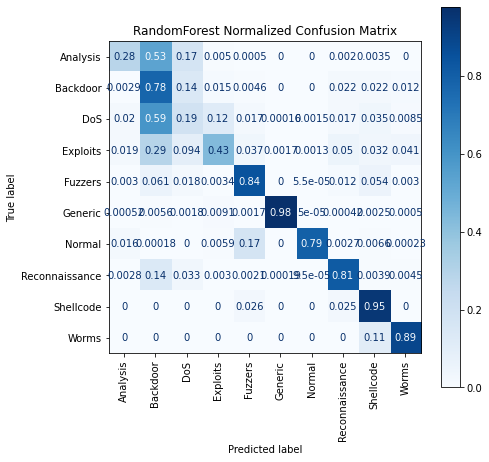

In [51]:
conf_mat_rf_best, class_rep_rf_best, rep_dict_rf_best, acc_rf_best = gen_metrics(y_train, y_pred_rf_best)
print(class_rep_rf_best)
plt_norm_confmat(rf_best, training_data_std, y_train, 'RandomForest Normalized Confusion Matrix', 
                 fname='rf_best_conf_mat', labels=class_names)
plt.show()

That looks decent.  Are there other parameters we should conisder tuning to improve the results?  
We should also train on each of the feature subsets so we can compare fairly with the previous models.  We may also want to go back and use the most important features identified here on the earlier models to see if performance improves.

I also wonder if more leaf nodes are needed, we settled on 128, but that was the highest value searched...

In [54]:
params_3 = {'max_leaf_nodes':[128, 192, 256, 320]}
rf_gs_3 = GridSearchCV(RandomForestClassifier(n_estimators=750, class_weight='balanced_subsample'), params_3, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [55]:
rf_gs_3_results = rf_gs_3.fit(training_data_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [56]:
print(rf_gs_3_results.best_params_)
print(rf_gs_3_results.best_score_)

{'max_leaf_nodes': 320}
0.723618548998808


slightly better accuracy...but still hitting that top value...is it worth going higher?

In [57]:
params_4 = {'max_leaf_nodes':[320, 384, 448, 512]}
rf_gs_4 = GridSearchCV(RandomForestClassifier(n_estimators=750, class_weight='balanced_subsample'), params_4, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [58]:
rf_gs_4_results = rf_gs_4.fit(training_data_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [59]:
print(rf_gs_4_results.best_params_)
print(rf_gs_4_results.best_score_)

{'max_leaf_nodes': 512}
0.728785623442321


.5% better than the last run, maybe we're nearing the limit...but maybe just set it to `None` for unlimited leaves?

In [60]:
rf_best_new = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', n_jobs=-1)
rf_best_new.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=750,
                       n_jobs=-1)

In [61]:
# save the test set for final models
y_pred_rf_best_new = cross_val_predict(rf_best_new, training_data_std, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.04      0.12      0.07      2000
           1       0.06      0.20      0.09      1746
           2       0.31      0.29      0.30     12264
           3       0.73      0.61      0.66     33393
           4       0.53      0.68      0.60     18184
           5       0.90      0.98      0.94     40000
           6       0.90      0.78      0.83     56000
           7       0.89      0.74      0.81     10491
           8       0.66      0.63      0.65      1133
           9       0.66      0.18      0.28       130

    accuracy                           0.73    175341
   macro avg       0.57      0.52      0.52    175341
weighted avg       0.77      0.73      0.74    175341



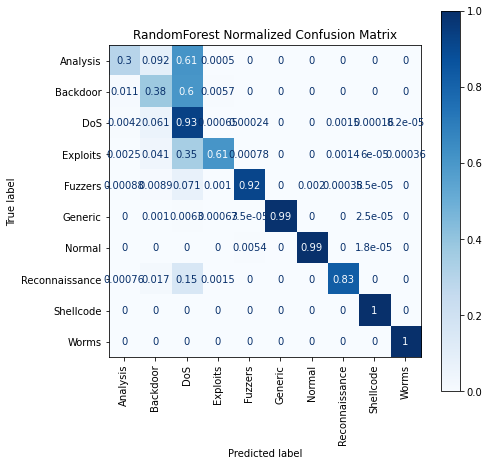

In [62]:
conf_mat_rf_best_new, class_rep_rf_best_new, rep_dict_rf_best_new, acc_rf_best_new = gen_metrics(y_train, y_pred_rf_best_new)
print(class_rep_rf_best_new)
plt_norm_confmat(rf_best_new, training_data_std, y_train, 'RandomForest Normalized Confusion Matrix', 
                 fname='rf_best_new_conf_mat', labels=class_names)
plt.show()

In [65]:
joblib.dump(rf_best_new, './data/rf_best_new.pkl')

['./data/rf_best_new.pkl']

This is looking better, what are the feature importances?  
What other parameters could we tune?